In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import time
import datetime

import QuantLib as ql
from scipy.optimize import minimize

current_time = pd.Timestamp(year=2021, month=8, day=3, hour=12)
current_price = 4300.

def delta_t(m):

    now = current_time
    delta_t = m - now
    year_dt = datetime.timedelta(365,0,0,0)

    return round(delta_t/year_dt, 6)

def date_pd_to_ql(date):
    date = pd.to_datetime(date)
    day = date.day
    month = date.month
    year = date.year

    return ql.Date(day, month, year)


df = pd.read_csv(r'spx_SABR.csv')

df['Date'] = pd.to_datetime(df['Date'], format='%y%m%d')
maturities = df['Date'].unique()

In [7]:
#PLOTTING

#Plot volatility Surface
def plot_vol_surface(vol_surface, plot_years=np.arange(0.1, 3, 0.1), plot_strikes=np.arange(70, 130, 1), funct='blackVol'):
    if type(vol_surface) != list:
        surfaces = [vol_surface]
    else:
        surfaces = vol_surface

    fig = plt.figure(figsize=(20, 8))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Maturities')
    ax.set_zlabel('Implied Volatility')
    X, Y = np.meshgrid(plot_strikes, plot_years)

    for surface in surfaces:
        method_to_call = getattr(surface, funct)

        Z = np.array([method_to_call(float(y), float(x)) 
                      for xr, yr in zip(X, Y) 
                          for x, y in zip(xr,yr) ]
                     ).reshape(len(X), len(X[0]))

        surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, linewidth=0.3)


def plot2d(x, y):
    fig = plt.figure(figsize=(6, 4), dpi=80)
    ax = fig.gca()

    ax.plot(x, y)

    ax.set_xlabel('Strikes')
    ax.set_ylabel('Implied Volatility')
    ax.set_xbound(4000, 6000)

    plt.show()

def plot3d(x, y, z, rng=current_price, angle=45, scatter=True):
    fig = plt.figure(figsize=(15, 8), dpi=80)

    ax = plt.axes(projection='3d')
    if scatter:
        ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=.5)
    else:
        ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none');



    ax.set_xlabel('Maturities')
    ax.set_ylabel('Strikes')
    ax.set_zlabel('Implied Volatility')

    ax.set_ylim((current_price - rng, current_price + rng))
    
    ax.invert_xaxis()
    ax.view_init(20, angle)
    

    plt.show()


C:\Users\somig\AppData\Local\Temp/ipykernel_6780/508323395.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


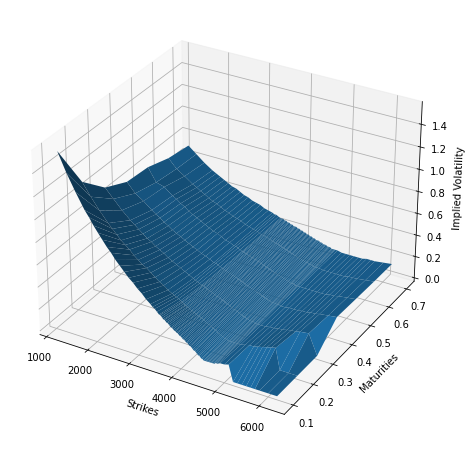

In [11]:
# BLACK VOLATILITY SURFACE

vols = [np.array(df[df["Date"] == maturities[m]]["IV"]) for m in range(len(maturities))]
volMatrix = ql.Matrix(len(vols[0]), len(vols))

for i in range(len(vols)):
    for j in range(len(vols[i])):
        volMatrix[j][i] = vols[i][j]

today = ql.Date(3, 8, 2021)
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()
dates = [date_pd_to_ql(d) for d in maturities]
strikes = df["Strike"].unique()

black_var_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, volMatrix, day_count)
black_var_surface.enableExtrapolation()

plot_vol_surface(vol_surface=black_var_surface , plot_years=np.arange(0.1, .8, 0.1), plot_strikes=strikes, funct='blackVol')

In [118]:
#CALIBRATE VOLATILITY SURFACE

def volatilitySmileSABR(maturity, shift=0, beta=1):

    option = df[df["Date"] == maturity]
    dt = delta_t(pd.to_datetime(maturity))

    strikes = option["Strike"]
    fwd = current_price
    expiryTime = dt
    marketVols = option["IV"]*10**-2

    def set_beta():
        return beta

    def f(params):

        alpha, beta, nu, rho = params

        alpha = max(alpha, 1e-8) # Avoid alpha going negative
        beta = set_beta()
        nu = max(nu, 1e-8) # Avoid nu going negative
        rho = max(rho, -0.999) # Avoid rhp going < -1.0
        rho = min(rho, 0.999) # Avoid rho going > 1.0

        vols = np.array([
        ql.sabrVolatility(strike + shift, fwd + shift, expiryTime, alpha, beta, nu, rho)
        for strike in strikes
        ])

        error = ((vols - np.array(marketVols))**2 ).mean() **.5

        return error

    cons = (
    {'type': 'ineq', 'fun': lambda x: x[0]},
    # {'type': 'ineq', 'fun': lambda x: 0.99 - x[1]},
    # {'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: x[2]},
    {'type': 'ineq', 'fun': lambda x: .99 - x[3]**2}
    )

    x = [.1, set_beta(), .01, .1]

    result = minimize(f, x, constraints=cons, method="SLSQP")
    error = result['fun']
    [alpha, beta, nu, rho] = result['x']

    newVols = [ql.sabrVolatility(strike, fwd, expiryTime, alpha, beta, nu, rho) for strike in strikes]
    
    return dict(vols=newVols, error=error, params={"alpha": alpha, "beta": beta, "nu": nu, "rho": rho})

def volatilitySurfaceSABR(method="normal", beta=1, shift=0):

    vol_surface_vector, errors, _alpha, _beta, _nu, _rho = [], [], [], [], [], []
    SABRVolMatrix = ql.Matrix(len(strikes), len(maturities))
    
    for i,m in enumerate(maturities):
        volSABR = volatilitySmileSABR(maturity=m, beta=beta, shift=shift)

        _alpha.append(volSABR["params"]["alpha"])
        _beta.append(volSABR["params"]["beta"])
        _nu.append(volSABR["params"]["nu"])
        _rho.append(volSABR["params"]["rho"])
        
        errors.append(volSABR["error"])

        smile = volSABR["vols"]
        vol_surface_vector.extend(smile)

        #constructing the SABRVolatilityMatrix
        for j in range(len(smile)):
            SABRVolMatrix[j][i] = smile[j]
    
    return dict(vols=vol_surface_vector, volMatrix=SABRVolMatrix, e=errors, a=_alpha, b=_beta, n=_nu, r=_rho)


C:\Users\somig\AppData\Local\Temp/ipykernel_6780/508323395.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


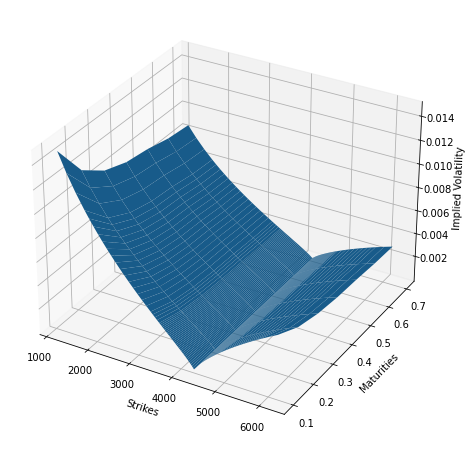

In [119]:
#SABR VOLATILITY SURFACE

volatility_surface = volatilitySurfaceSABR()
SABRVolMatrix = volatility_surface["volMatrix"]

today = ql.Date(3, 8, 2021)
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()
dates = [date_pd_to_ql(d) for d in maturities]
strikes = df["Strike"].unique()

SABR_vol_surface  = ql.BlackVarianceSurface(today, calendar, dates, strikes, SABRVolMatrix, day_count)
SABR_vol_surface.enableExtrapolation()

plot_vol_surface(vol_surface=SABR_vol_surface , plot_years=np.arange(0.1, .8, 0.1), plot_strikes=strikes, funct='blackVol')

In [126]:
method1 = volatilitySurfaceSABR(beta=1, shift=0)
method2 = volatilitySurfaceSABR(beta=.5, shift=0)
method3 = volatilitySurfaceSABR(beta=.1, shift=0)

method3["b"][1]

0.1

,alpha,beta,nu,rho
2021-08-06,0.000024,1.0,0.595653,-0.994905
2021-08-09,0.000015,1.0,0.310481,-0.994905
2021-08-11,0.000113,1.0,0.208556,0.097318
2021-08-13,0.000110,1.0,0.178177,0.097298
2021-08-16,0.000108,1.0,0.157750,0.097736
2021-08-20,0.000108,1.0,0.157742,0.097735
2021-08-23,0.000106,1.0,0.121651,0.099064
2021-08-25,0.000106,1.0,0.117400,0.099130
2021-08-27,0.000105,1.0,0.113082,0.099200
2021-09-10,0.000103,1.0,0.089581,0.099952


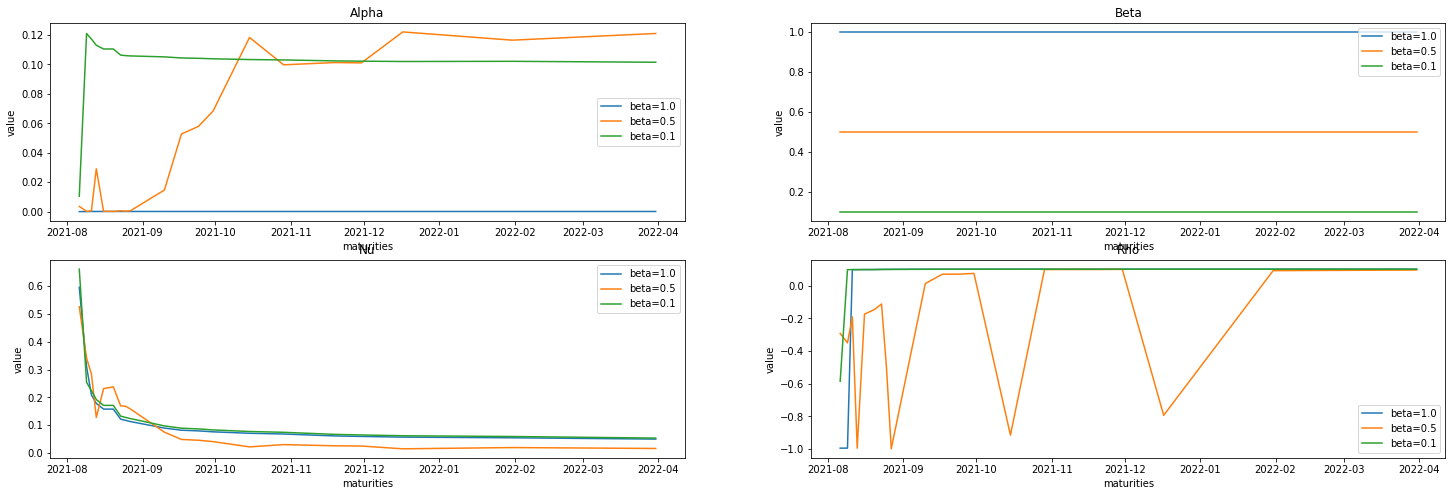

In [129]:
fig, axs = plt.subplots(2, 2, figsize=(25,8))
for method in [method1, method2, method3]:
    axs[0, 0].plot(maturities, method["a"], label="beta={}".format(method["b"][1]))
    axs[0, 0].set_title('Alpha')
    axs[0, 0].set(xlabel='maturities', ylabel='value')
    axs[0, 0].legend()
    axs[0, 1].plot(maturities, method["b"], label="beta={}".format(method["b"][1]))
    axs[0, 1].set_title('Beta')
    axs[0, 1].set(xlabel='maturities', ylabel='value')
    axs[0, 1].legend()
    axs[1, 0].plot(maturities, method["n"], label="beta={}".format(method["b"][1]))
    axs[1, 0].set_title('Nu')
    axs[1, 0].set(xlabel='maturities', ylabel='value')
    axs[1, 0].legend()
    axs[1, 1].plot(maturities, method["r"], label="beta={}".format(method["b"][1]))
    axs[1, 1].set_title('Rho')
    axs[1, 1].set(xlabel='maturities', ylabel='value')
    axs[1, 1].legend()

d = {'alpha': volatility_surface["a"], 'beta': volatility_surface["b"], 'nu': volatility_surface["n"], 'rho': volatility_surface["r"]}
pd.DataFrame(data=d, index=maturities)


C:\Users\somig\AppData\Local\Temp/ipykernel_6780/508323395.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


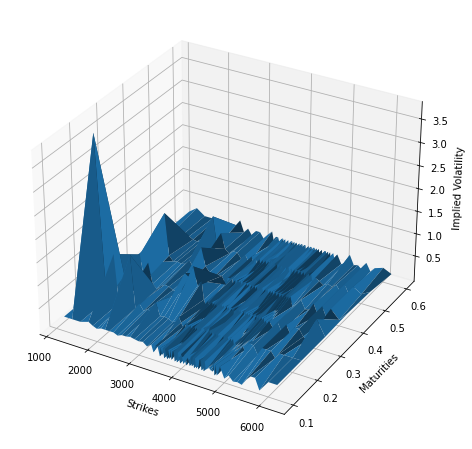

In [24]:
#DUPIRE LOCAL VOLATILITY SURFACE (NOT PLOTTABLE)

spot_quote = ql.QuoteHandle(ql.SimpleQuote(current_price))

rate = 0.0
riskFreeCurve = ql.FlatForward(today, rate, ql.Actual365Fixed())
flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
dividend_ts = ql.YieldTermStructureHandle(riskFreeCurve)


black_var_surface .setInterpolation("bicubic")
local_vol_handle = ql.BlackVolTermStructureHandle(black_var_surface)
local_vol_surface = ql.NoExceptLocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote, .25)

# Plot the Dupire surface ...
local_vol_surface.enableExtrapolation()
plot_vol_surface(local_vol_surface, plot_years=np.arange(0.1, .657, 0.1), plot_strikes=strikes, funct='localVol')


In [25]:
 #HESTON MODEL CALIBRATION functions

def setup_helpers(engine, expiration_dates, strikes, 
                  data, ref_date, spot, yield_ts, 
                  dividend_ts):
    heston_helpers = []
    grid_data = []
    for i, date in enumerate(expiration_dates):
        for j, s in enumerate(strikes):
            t = (date - ref_date )
            p = ql.Period(t, ql.Days)
            vols = data[i][j]
            helper = ql.HestonModelHelper(
                p, calendar, spot, s, 
                ql.QuoteHandle(ql.SimpleQuote(vols)),
                yield_ts, dividend_ts)
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
            grid_data.append((date, s))
    return heston_helpers, grid_data

def cost_function_generator(model, helpers,norm=False):
    def cost_function(params):
        params_ = ql.Array(list(params))
        model.setParams(params_)
        error = [h.calibrationError() for h in helpers]
        if norm:
            return np.sqrt(np.sum(np.abs(error)))
        else:
            return error
    return cost_function

def calibration_report(helpers, grid_data, detailed=False):
    avg = 0.0
    if detailed:
        print ("%15s %25s %15s %15s %20s") % (
            "Strikes", "Expiry", "Market Value", 
             "Model Value", "Relative Error (%)")
        print ("="*100)
    for i, opt in enumerate(helpers):
        err = (opt.modelValue()/opt.marketValue() - 1.0)
        date,strike = grid_data[i]
        if detailed:
            print ("%15.2f %25s %14.5f %15.5f %20.7f ") % (
                strike, str(date), opt.marketValue(), 
                opt.modelValue(), 
                100.0*(opt.modelValue()/opt.marketValue() - 1.0))
        avg += abs(err)
    avg = avg*100.0/len(helpers)
    if detailed: print ("-"*100)
    summary = "Average Abs Error (%%) : %5.9f" % (avg)
    print (summary)
    return avg
    
def setup_model(_yield_ts, _dividend_ts, _spot, 
                init_condition=(0.02,0.2,0.5,0.1,0.01)):
    theta, kappa, sigma, rho, v0 = init_condition
    process = ql.HestonProcess(_yield_ts, _dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(_spot)), 
                           v0, kappa, theta, sigma, rho)
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model) 
    return model, engine
summary= []


In [27]:
#HESTON MODEL CALIBRATION PARAMETRES

from scipy.optimize import differential_evolution
from scipy.optimize import least_squares
from scipy.optimize import root

expiration_dates, data, calculation_date = (dates, vols, today)

# Set up the flat risk-free curves
riskFreeCurve = ql.FlatForward(today, rate, ql.Actual365Fixed())
flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
yield_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, rate, ql.Actual365Fixed()))

dividend_ts = ql.YieldTermStructureHandle(riskFreeCurve)


model1, engine1 = setup_model(
    yield_ts, dividend_ts, current_price, 
    init_condition=(0.2,2,5,1,0.1))
heston_helpers1, grid_data1 = setup_helpers(
    engine1, expiration_dates, strikes, data, 
    calculation_date, current_price, yield_ts, dividend_ts
)
initial_condition = list(model1.params())

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model1.calibrate(heston_helpers1, lm, 
                 ql.EndCriteria(500, 300, 1.0e-8,1.0e-8, 1.0e-8))
theta, kappa, sigma, rho, v0 = model1.params()

error = calibration_report(heston_helpers1, grid_data1)
summary.append(["QL LM1", error] + list(model1.params()))


NameError: name 'spot' is not defined

C:\Users\somig\AppData\Local\Temp/ipykernel_11056/508323395.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


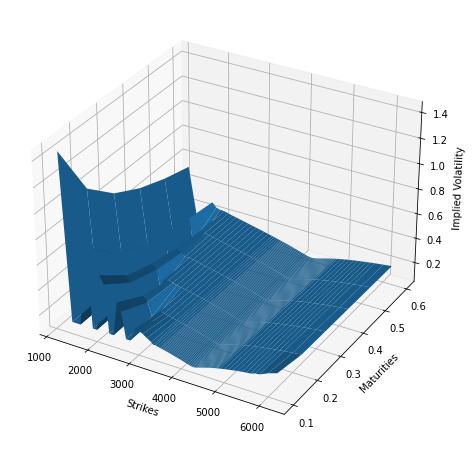

In [ ]:
process = ql.HestonProcess(flat_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(spot)), v0, kappa, theta, sigma, rho)

# Boilerplate to get to the Vol Surface object
heston_model = ql.HestonModel(process)
heston_handle = ql.HestonModelHandle(heston_model)
heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

# Plot the vol surface ...
plot_vol_surface(heston_vol_surface, plot_years=np.arange(0.1, .657, 0.1), plot_strikes=strikes, funct='blackVol')


In [ ]:
expiration_dates, data, calculation_date = (dates, vols, today)
